# Classifying Genetic Mutation 



1. Packages

   1. Downloading Sent2Vec and Installing

2. Downloading data

3. Preprocessing data

4. Primary data analysis

5. Data featurization

   1. Text Feature

      - TF-IDF 

      - Using pre-trained model
        - Downloading BioSent2Vec
        - Loading BioSent2Vec
        - Applying BioSent2Vec on TEXT
   2. Categorical Features
      - Response encoding
      - One-hot encoding

6. Secondary data analysis

   1. Visualizing high dimensional text features by t-SNE
   2. Visualizing Gene & Variation features by  t-SNE

7. ML model building

   1. Linear models
      1. SVM 
      2. Logistic Regression (SGD)
   2. Tree-base models
      1. Decision tree

8. Conclusion
   

<a name="cell-id1"></a>
# Packages

## Downloading Sent2Vec and Installing

In [1]:
! curl --header 'Host: codeload.github.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:86.0) Gecko/20100101 Firefox/86.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://github.com/epfml/sent2vec' --header 'DNT: 1' --cookie '_octo=GH1.1.1157954504.1616399111; logged_in=yes; tz=Asia%2FKolkata; color_mode=%7B%22color_mode%22%3A%22dark%22%2C%22light_theme%22%3A%7B%22name%22%3A%22light%22%2C%22color_mode%22%3A%22light%22%7D%2C%22dark_theme%22%3A%7B%22name%22%3A%22dark%22%2C%22color_mode%22%3A%22dark%22%7D%7D; dotcom_user=akshayonly' --header 'Upgrade-Insecure-Requests: 1' --header 'Sec-GPC: 1' 'https://codeload.github.com/epfml/sent2vec/zip/refs/heads/master' --output 'sent2vec-master.zip'
! unzip sent2vec-master && cd sent2vec-master && make && pip install .

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  355k    0  355k    0     0  1770k      0 --:--:-- --:--:-- --:--:-- 1770k
Archive:  sent2vec-master.zip
f00a1b67f4330e5be99e7cc31ac28df94deed9ac
   creating: sent2vec-master/
  inflating: sent2vec-master/.gitignore  
  inflating: sent2vec-master/Dockerfile  
  inflating: sent2vec-master/LICENSE  
  inflating: sent2vec-master/Makefile  
  inflating: sent2vec-master/README.md  
  inflating: sent2vec-master/get_sentence_embeddings_from_pre-trained_models.ipynb  
  inflating: sent2vec-master/paper-sent2vec.pdf  
 extracting: sent2vec-master/requirements.txt  
  inflating: sent2vec-master/setup.py  
   creating: sent2vec-master/src/
  inflating: sent2vec-master/src/args.cc  
  inflating: sent2vec-master/src/args.h  
  inflating: sent2vec-master/src/asvoid.h  
  inflating: sent2vec-master/src/dictionary.cc  
  inflating: sent2vec-m

## Libraries

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns

import re
from tqdm import tqdm
from datetime import datetime

import sent2vec

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('punkt')

palette = sns.color_palette("bright", 9)
plt.style.use('bmh')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
start=datetime.now()

# Downloading data

In [5]:
# Train Texts
! curl --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:86.0) Gecko/20100101 Firefox/86.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www.kaggle.com/' --header 'DNT: 1' --header 'Upgrade-Insecure-Requests: 1' --header 'Sec-GPC: 1' 'https://storage.googleapis.com/kagglesdsdata/competitions/6841/44307/training_text.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1616748114&Signature=PCcLSRN0v8r2loPEYY0WdqNPem%2FsZHwTMCEGUtJrTLuW0LvOZ5lt6kl7nB%2FMKpqe67FN1%2BPDuZvC%2B8QWg6wIXLWEmz0f0UE0x5yYW5suq7AaRzedE8A6HZuDRj9mmhb1lYhksZL04ZAB2VYADur90n%2Fyhpsgt6aQ5VuEKWGHQuYH7k4X7NDkTPmfC0cTp4qujfz5I%2BagifBdFnZj%2FQMzMH2onbMJi4%2FAY806%2FDsEPQ5YKZZ4bNqOyjTNrEDWcdKu1TVQSlmrTnwOykSNK1s7viy%2Bhnrx2trZa8LvEMiP2GxDXsnFcK7IdhPJWevk5UX9m9d3vXi%2BVsJLoJuTiizezw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtraining_text.zip' --output 'training_text.zip' && unzip training_text.zip

# Train Variants
! curl --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:86.0) Gecko/20100101 Firefox/86.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www.kaggle.com/' --header 'DNT: 1' --header 'Upgrade-Insecure-Requests: 1' --header 'Sec-GPC: 1' 'https://storage.googleapis.com/kagglesdsdata/competitions/6841/44307/training_variants.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1616748147&Signature=HYq8rHWpYzz%2B2hIPZV6XWullEV0yQ3oepX6SicRqb5EU6MFOwznQLKprpTK2M2yiS3yvzVz%2Bzft0tlkQBFgF33JTwgSv3aZubyUvowDUrWHqYho%2FYnzWl8sJXl0x9nIFon4hU8rdg9JMbve9nyVvz%2F28fYUaapk73c7ZWC5SYOmPzSwgEKnxDsW8Vn2G4U6fe34i4JW1FveXebIA9wtYBG6%2F%2FC8Soh46d5qTI%2B6LHIo%2BmaIXmnL7jmpNpuL3wFmbN6tMTUG1f7yPOhRKreglmXUVFjDqqnkWRmvfwAHdzr%2FdpgKw4Ahu2EivDehaewTy%2B%2BTyOKDLutNgxj2nfbWfVA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtraining_variants.zip' --output 'training_variants.zip' && unzip training_variants.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60.9M  100 60.9M    0     0  78.3M      0 --:--:-- --:--:-- --:--:-- 78.2M
Archive:  training_text.zip
  inflating: training_text           
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24831  100 24831    0     0  93349      0 --:--:-- --:--:-- --:--:-- 93349
Archive:  training_variants.zip
  inflating: training_variants       


In [6]:
! ls -I *.zip

training_text.zip  training_variants.zip


<a name="cell-id3"></a>
# Data Preprocessing

In [7]:
variants_data = pd.read_csv('/content/training_variants', index_col=False)
variants_data.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [8]:
texts_data = pd.read_csv('/content/training_text', 
                         sep="\|\|", 
                         engine="python", 
                         names=["ID","TEXT"], 
                         skiprows=1)

texts_data.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


## Merging variants and texts dataframes

In [9]:
data = pd.merge(texts_data, variants_data, on='ID', how='left')

data.head()

,ID,TEXT,Gene,Variation,Class
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4


## Highlevel overview

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   TEXT       3316 non-null   object
 2   Gene       3321 non-null   object
 3   Variation  3321 non-null   object
 4   Class      3321 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


1. There are 3321 entries in the dataframe.
2. Leaving ``Class`` column which is numerical representation of genetic mutation classes, rest are object datatype i.e. categorical and text.
3. The ``TEXT`` column have 05 entries lesser than the total 3321, we'd look at them later.

In [11]:
data['Class'].describe()

count    3321.000000
mean        4.365854
std         2.309781
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max         9.000000
Name: Class, dtype: float64

In [12]:
# Removing from memory (RAM) as we're gonna load an 22GB pretrained model later
# we need to do some memory hacks. 

%xdel variants_data
%xdel texts_data

## Preprocessing

### NaN values

In [13]:
data[data.isnull().any(axis=1)]

,ID,TEXT,Gene,Variation,Class
1109,1109,NaN,FANCA,S1088F,1
1277,1277,NaN,ARID5B,Truncating Mutations,1
1407,1407,NaN,FGFR3,K508M,6
1639,1639,NaN,FLT1,Amplification,6
2755,2755,NaN,BRAF,G596C,7


- There are 05 rows in the data in the ``'TEXT'`` column which are NaN
- We'd  remove them, as these are text base and we cannot replace them with other values.

In [14]:
data.dropna(subset = ["TEXT"], inplace=True)

### Standard NLP preprocessing
- Removing stop words
- Removing puntuations

In [15]:
stop_words = set(stopwords.words('english'))

def text_processing(text):
  """Processing the sentence (single entry)."""

  text = re.sub('\s+',' ', text)
  text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
  text = text.lower()

  tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]

  return ' '.join(tokens)

In [16]:
for index, text in tqdm(data.TEXT.iteritems()):
  data["TEXT"][index] = text_processing(text)

3316it [02:35, 21.30it/s]


In [17]:
data.Gene = data.Gene.str.replace(' ', '_')
data.Variation = data.Variation.str.replace(' ', '_')

In [18]:
data.head(2)

,ID,TEXT,Gene,Variation,Class
0,0,cyclin dependent kinases cdks regulate variety...,FAM58A,Truncating_Mutations,1
1,1,abstract background non small cell lung cancer...,CBL,W802*,2


In [19]:
# Copying newly created dataframe into csv
data.to_csv('CGM-processed.csv', index=False)

In [20]:
# Copying to google drive
!cp -r /content/CGM-processed.csv /content/drive/MyDrive/Data/CGV-Data

<a name="cell-id4"></a>
# Primary data analysis

<a name="cell-id5"></a>
# Data featurization

In [21]:
y = np.array(data['Class'])

In [22]:
X = data[data.columns[1:4]]

In [23]:
# Splitting the data into train and test

x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, stratify=y)

In [24]:
x_train.shape

(2487, 3)

In [25]:
x_test.shape

(829, 3)

In [26]:
x_test.head()

,TEXT,Gene,Variation
2887,mutation screening breast ovarian cancer predi...,BRCA2,P375S
2533,genetic screening breast ovarian cancer suscep...,BRCA1,Q1785H
2605,abstract brca1 gene individuals risk breast ov...,BRCA1,V1665M
1869,genes encoding components pi3k akt mtor signal...,MTOR,F1888I
1356,protein kinase v akt murine thymoma viral onco...,AKT1,P42T


## Categorical

### One-hot encoding

In [27]:
gene_ohe = CountVectorizer()
ohe_tr_gene = gene_ohe.fit_transform(np.array(x_train['Gene']))
ohe_ts_gene = gene_ohe.transform(np.array(x_test['Gene']))

In [28]:
# Normalising the values
ohe_tr_gene=normalize(ohe_tr_gene, axis=0)
ohe_ts_gene=normalize(ohe_ts_gene, axis=0)

In [29]:
ohe_ts_gene.todense().shape

(829, 244)

In [30]:
var_ohe = CountVectorizer()
ohe_tr_var = var_ohe.fit_transform(np.array(x_train['Variation']))
ohe_ts_var = var_ohe.transform(np.array(x_test['Variation']))

In [31]:
# Normalising the values
ohe_tr_var=normalize(ohe_tr_var, axis=0)
ohe_ts_var=normalize(ohe_ts_var, axis=0)

In [32]:
ohe_ts_var.shape

(829, 2280)

### Response-encoding

In [33]:
def probabilities(x, y, class_label):
    """
    Computes probability score required for response encoding
    """

    total_outcome = dict(x.value_counts())
    count_outcome = x[y==class_label].value_counts()

    prob_class = dict()
    for feature in x:
        if feature in count_outcome.keys():
            prob_class[feature] = np.float(count_outcome[feature]/total_outcome[feature])
        else:
            prob_class[feature] = np.float(0)
    
    return prob_class

def response_fit(x, y):
    
    prob_1 = probabilities(x, y, class_label=1)
    prob_2 = probabilities(x, y, class_label=2)
    prob_3 = probabilities(x, y, class_label=3)
    prob_4 = probabilities(x, y, class_label=4)
    prob_5 = probabilities(x, y, class_label=5)
    prob_6 = probabilities(x, y, class_label=6)
    prob_7 = probabilities(x, y, class_label=7)
    prob_8 = probabilities(x, y, class_label=8)
    prob_0 = probabilities(x, y, class_label=0)
    
    score = dict()
    for category in x.unique():
        score[category] = (prob_1[category], prob_2[category], prob_3[category], 
                           prob_4[category], prob_5[category], prob_6[category],
                           prob_7[category], prob_8[category], prob_0[category])
    
    return score

def response_transform(scores, x):
    """"""
    response = list()
    for category in x:
      if category in scores.keys():
        response.append(scores[category])
      else:
        response.append((0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5))
        
    return np.array(response)          

In [34]:
score_dic = response_fit(x_train['Gene'], y_train)

res_tr_gene = response_transform(score_dic, x_train['Gene'])
res_ts_gene = response_transform(score_dic, x_test['Gene'])

In [35]:
res_ts_gene.shape

(829, 9)

In [36]:
score_dic = response_fit(x_train['Variation'], y_train)

res_tr_var = response_transform(score_dic, x_train['Variation'])
res_ts_var= response_transform(score_dic, x_test['Variation'])

In [37]:
res_ts_var.shape

(829, 9)

## Text

### TF-IDF 

In [38]:
vec_start = datetime.now()

tfidf = TfidfVectorizer(ngram_range=(2, 4), max_features=700)

tfidf_tr_text = tfidf.fit_transform(x_train['TEXT'])
tfidf_ts_text = tfidf.transform(x_test['TEXT'])

vec_end = datetime.now()
print(f"Took: {vec_end-vec_start}")

Took: 0:02:41.481648


In [39]:
tfidf_ts_text.shape

(829, 700)

In [40]:
%xdel tfidf

### Pretrained BioSent2Vec Model

#### Downloading the model

In [41]:
! wget --header 'Host: ftp.ncbi.nlm.nih.gov' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:86.0) Gecko/20100101 Firefox/86.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://github.com/ncbi-nlp/BioSentVec' --header 'DNT: 1' --header 'Upgrade-Insecure-Requests: 1' --header 'Sec-GPC: 1' 'https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioSentVec_PubMed_MIMICIII-bigram_d700.bin' --output-document 'BioSentVec_PubMed_MIMICIII-bigram_d700.bin'

--2021-03-25 20:53:09--  https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioSentVec_PubMed_MIMICIII-bigram_d700.bin
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.11, 2607:f220:41e:250::13, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22475736490 (21G) [application/octet-stream]
Saving to: ‘BioSentVec_PubMed_MIMICIII-bigram_d700.bin’

BioSentVec_PubMed_M  25%[====>               ]   5.30G  41.0MB/s    in 76s     

2021-03-25 20:54:26 (71.1 MB/s) - Connection closed at byte 5692653568. Retrying.

--2021-03-25 20:54:27--  (try: 2)  https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioSentVec_PubMed_MIMICIII-bigram_d700.bin
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 22475736490 (21G), 16783082922 (16G) remaining [application/oct

In [42]:
! ls 

BioSentVec_PubMed_MIMICIII-bigram_d700.bin  sent2vec-master.zip
CGM-processed.csv			    training_text
drive					    training_text.zip
sample_data				    training_variants
sent2vec-master				    training_variants.zip


#### Loading

In [43]:
# Model path
path = '/content/BioSentVec_PubMed_MIMICIII-bigram_d700.bin'

In [60]:
model = sent2vec.Sent2vecModel()
try:
    model.load_model(path)
except Exception as e:
    print(e)
print('model successfully loaded')

model successfully loaded


In [61]:
ptm_tr_text = list()
for text in tqdm(x_train['TEXT']):
  ptm_tr_text.append(model.embed_sentence(text)[0])

ptm_tr_text = np.array(ptm_tr_text)

100%|██████████| 2487/2487 [00:29<00:00, 84.48it/s]


In [62]:
ptm_tr_text.shape

(2487, 700)

In [63]:
ptm_ts_text = list()
for text in tqdm(x_test['TEXT']):
  ptm_ts_text.append(model.embed_sentence(text)[0])

ptm_ts_text = np.array(ptm_ts_text)

100%|██████████| 829/829 [00:10<00:00, 80.81it/s]


In [64]:
ptm_ts_text.shape

(829, 700)

In [65]:
%xdel model

## Concatenation

In [66]:
train_set_1 = np.hstack((tfidf_tr_text.toarray(), ohe_tr_var.toarray(), ohe_tr_gene.toarray()))
test_set_1 = np.hstack((tfidf_ts_text.toarray(), ohe_ts_var.toarray(), ohe_ts_gene.toarray()))

In [67]:
train_set_1.shape

(2487, 3224)

In [68]:
ptm_tr_text.shape

(2487, 700)

In [69]:
res_tr_var.shape

(2487, 9)

In [70]:
test_set_2 = np.hstack((ptm_ts_text, res_ts_var, res_ts_gene))

In [71]:

train_set_2 = np.hstack((ptm_tr_text, res_tr_var, res_tr_gene))

In [73]:
test_set_2.shape

(829, 718)

<a name="cell-id6"></a>
# Secondary data analysis

Text(0, 0.5, 'X2')

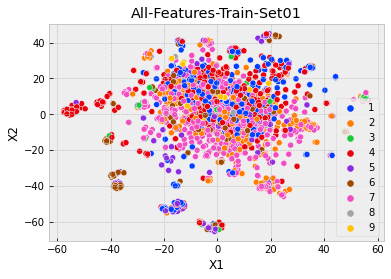

In [74]:
X_embedded = TSNE(n_components=2, perplexity=50).fit_transform(train_set_1) 
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], 
                hue=y_train, legend='full', palette=palette)
plt.title('All-Features-Train-Set01')
plt.xlabel('X1')
plt.ylabel('X2')

Text(0, 0.5, 'X2')

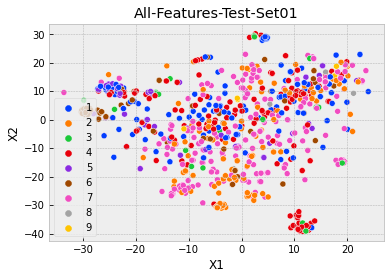

In [75]:
X_embedded = TSNE(n_components=2, perplexity=50).fit_transform(test_set_1) 
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], 
                hue=y_test, legend='full', palette=palette)
plt.title('All-Features-Test-Set01')
plt.xlabel('X1')
plt.ylabel('X2')

Text(0, 0.5, 'X2')

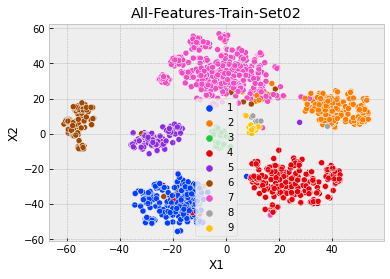

In [76]:
X_embedded = TSNE(n_components=2, perplexity=50).fit_transform(train_set_2) 
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], 
                hue=y_train, legend='full', palette=palette)
plt.title('All-Features-Train-Set02')
plt.xlabel('X1')
plt.ylabel('X2')

Text(0, 0.5, 'X2')

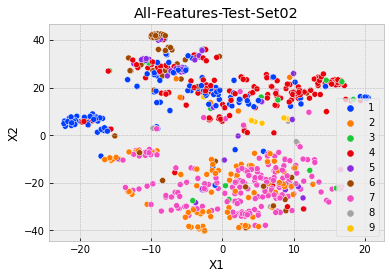

In [77]:
X_embedded = TSNE(n_components=2, perplexity=50).fit_transform(test_set_2) 
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], 
                hue=y_test, legend='full', palette=palette)
plt.title('All-Features-Test-Set02')
plt.xlabel('X1')
plt.ylabel('X2')

# ML model building

## Linear models

In [ ]:
svm_clf = SVC()

# defining parameter range
params = {'C': [0.1, 1, 10, 100, 1000], 
          'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
          'kernel': ['rbf', 'linear']} 

svm_cv_set2 = GridSearchCV(svm_clf, params, 
                           cv=5, n_jobs=-1,
                           verbose=2,
                           return_train_score=True).fit(train_set_2, y_train)    

In [ ]:
svm_cv_set2.best_score_

In [ ]:
svm_cv_set2.best_estimator_

In [ ]:
best_svm = svm_cv_set2.best_params_

In [ ]:
svm_clf = SVC(C=best_svm['C'], 
              gamma=best_svm['gamma'], 
              kernel=best_svm['kernel']).fit(train_set_2, y_train)

In [ ]:
grid_predictions = svm_clf.predict(test_set_2)

# print classification report
print(classification_report(y_test, grid_predictions))

## Tree-Based

### Hyper-parameter tunning set 01

In [ ]:
dt_clf = DecisionTreeClassifier(class_weight='balanced')

params = {
    'max_depth':[1, 5, 9],
    'min_samples_split':[5, 25, 50]}

dt_cv_set1 = GridSearchCV(dt_clf, params, 
                          cv=5, n_jobs=-1, 
                          return_train_score=True, 
                          scoring='roc_auc_ovr_weighted').fit(train_set_1, y_train)    

In [ ]:
dt_cv_set1.best_score_

In [ ]:
dt_cv_set1.best_params_

In [ ]:
dt_clf = DecisionTreeClassifier(max_depth=dt_cv_set1.best_params_['max_depth'], 
                min_samples_split=dt_cv_set1.best_params_['min_samples_split']).\
                fit(train_set_1, y_train)

In [ ]:
y_pred_set1 = dt_clf.predict_proba(test_set_1)
y_pred_set1=np.argmax(y_pred_set1, axis=1)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, y_pred_set1, labels=list(np.arange(1, 10))))

### Hyper-parameter tunning set 02

In [ ]:
# Since there is imbalance between all 09 classes
# I have selected class weights to be depend upon
# no of y values i.e 'balanced'

dt_clf = DecisionTreeClassifier()

params = {
    'max_depth':[1, 5, 9],
    'min_samples_split':[5, 25, 50]}

dt_cv_set2 = GridSearchCV(dt_clf, params, 
                          cv=5, n_jobs=-1, 
                          return_train_score=True).fit(train_set_2, y_train)    

In [ ]:
dt_cv_set2.best_score_

In [ ]:
dt_cv_set2.best_params_

In [ ]:
dt_clf = DecisionTreeClassifier(max_depth=dt_cv_set2.best_params_['max_depth'], 
                                min_samples_split=dt_cv_set2.best_params_['min_samples_split']).fit(train_set_2, y_train)

In [ ]:
y_pred_set2 = dt_clf.predict_proba(test_set_2)
y_pred_set2=np.argmax(y_pred_set2, axis=1)

In [ ]:
print(classification_report(y_test, y_pred_set2, labels=list(np.arange(1, 10))))

<a name="cell-id8"></a>
# Conclusion

In [ ]:
end=datetime.now()

print(f"Time took for whole Notebook - {end-start}")